## Lab 4: Coffee Lovers Unite

Elizabeth Berry

GSB 544

10/30/23

### Scrape Location Counts

In [195]:
# Step 1: Import data for coffee location counts

import pandas as pd
pd.set_option('display.max_rows', 500)

filepath = "/Users/elleberry/Desktop/Classes/MBA/GSB 544 - Computing and Machine Learning/Data/df_lab4_scraped.csv"

coffeedata = pd.read_csv(filepath)
coffeedata = coffeedata.rename(columns={'State_x': 'State'})

In [196]:
# Step 2: Create state name funtion for creating abbreviated state column

def stateabb(state_name):
    state_abbreviations = {
        "Alabama": "AL",
        "Alaska": "AK",
        "Arizona": "AZ",
        "Arkansas": "AR",
        "California": "CA",
        "Colorado": "CO",
        "Connecticut": "CT",
        "District of Columbia": "D.C.",
        "Delaware": "DE",
        "Florida": "FL",
        "Georgia": "GA",
        "Hawaii": "HI",
        "Idaho": "ID",
        "Illinois": "IL",
        "Indiana": "IN",
        "Iowa": "IA",
        "Kansas": "KS",
        "Kentucky": "KY",
        "Louisiana": "LA",
        "Maine": "ME",
        "Maryland": "MD",
        "Massachusetts": "MA",
        "Michigan": "MI",
        "Minnesota": "MN",
        "Mississippi": "MS",
        "Missouri": "MO",
        "Montana": "MT",
        "Nebraska": "NE",
        "Nevada": "NV",
        "New Hampshire": "NH",
        "New Jersey": "NJ",
        "New Mexico": "NM",
        "New York": "NY",
        "North Carolina": "NC",
        "North Dakota": "ND",
        "Ohio": "OH",
        "Oklahoma": "OK",
        "Oregon": "OR",
        "Pennsylvania": "PA",
        "Rhode Island": "RI",
        "South Carolina": "SC",
        "South Dakota": "SD",
        "Tennessee": "TN",
        "Texas": "TX",
        "Utah": "UT",
        "Vermont": "VT",
        "Virginia": "VA",
        "Washington": "WA",
        "West Virginia": "WV",
        "Wisconsin": "WI",
        "Wyoming": "WY",
    }

    state_abbreviation = state_abbreviations.get(state_name)

    return state_abbreviation

In [197]:
# Step 3: Parse, merge, tidy data to have a row for each state and two columns: state abbrevation, location count.

coffeedata['State Abbreviation'] = coffeedata['State'].apply(stateabb)

state_location_counts = coffeedata.groupby('State Abbreviation')['Location Count'].sum().reset_index()

state_location_counts.columns = ['State Abbreviation', 'Location Count']

### Supplemental Data

In [198]:
# Step 4: Scrape state names and populations from this wikipedia page. 

import requests
from bs4 import BeautifulSoup

url = "https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population"

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

In [199]:
tables = soup.find_all("table",
                      attrs={
                          "class": "wikitable sortable"
                      })

if tables:

    states = []
    populations = []

    rows = table.find_all('tr')[1:]

    for row in rows:
        columns = row.find_all('td')
        if len(columns) >= 4:
            state = columns[2].get_text(strip=True)
            population = int(columns[3].get_text(strip=True).replace(',', ''))  # Convert to an integer

            states.append(state)
            populations.append(population)

    df = pd.DataFrame({
        'State': states,
        'Population': populations
    })

else:
    print("No matching tables found on the page.")

In [200]:
wikidata = pd.DataFrame({
    'State': states,
    'Population': populations
})

In [201]:
# Convert the state names to abbreviations and merge data with coffee dataset.

wikidata['State Abbreviation'] = wikidata['State'].apply(stateabb)

merged_data = pd.merge(coffeedata, wikidata, on='State Abbreviation', how='left')

merged_data = merged_data.drop('State_y', axis=1)

merged_data = merged_data.rename(columns={'State_x': 'State'})

In [202]:
# Step 5: Get financial data for coffee chains

coffee_chain_revenue_list = [
    ("Starbucks", 32250000000),
    ("Dunkin' Donuts", 1250000000),
    ("Peet's Coffee & Tea", 983000000),
    ("Tim Horton's", 2630000000),
    ("Panera Bread", 2800000000),
    ("Caribou Coffee", 262000000),
    ("Au Bon Pain", 41000000),
    ("The Coffee Bean & Tea Leaf", 500000000),
    ("McDonald's", 2420000000),
]

for index, row in merged_data.iterrows():
    chain_name = row['Coffee Chain']
    
    for chain, revenue in coffee_chain_revenue_list:
        if chain_name == chain:
            # Add the revenue to new column
            merged_data.at[index, 'Revenue'] = revenue
            break 

In [203]:
# Step 6: Create region variable

region_mapping = {
    "Northeast": {
        "New England": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont"],
        "Middle Atlantic": ["New Jersey", "New York", "Pennsylvania"],
    },
    "Midwest": {
        "East North Central": ["Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin"],
        "West North Central": ["Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"],
    },
    "South": {
        "South Atlantic": ["Delaware", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", "Virginia", "District of Columbia", "West Virginia"],
        "East South Central": ["Alabama", "Kentucky", "Mississippi", "Tennessee"],
        "West South Central": ["Arkansas", "Louisiana", "Oklahoma", "Texas"],
    },
    "West": {
        "Mountain": ["Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming"],
        "Pacific": ["Alaska", "California", "Hawaii", "Oregon", "Washington"],
    }
}

# Create region column
merged_data['Region'] = None

for region, divisions in region_mapping.items():
    for division, states in divisions.items():
        merged_data.loc[merged_data['State'].isin(states), 'Region'] = region

### Analyze

In [204]:
chain_state_counts = merged_data.groupby(['Coffee Chain', 'State'])['Location Count'].sum().reset_index()

chain_region_counts = merged_data.groupby(['Coffee Chain', 'Region'])['Location Count'].sum().reset_index()

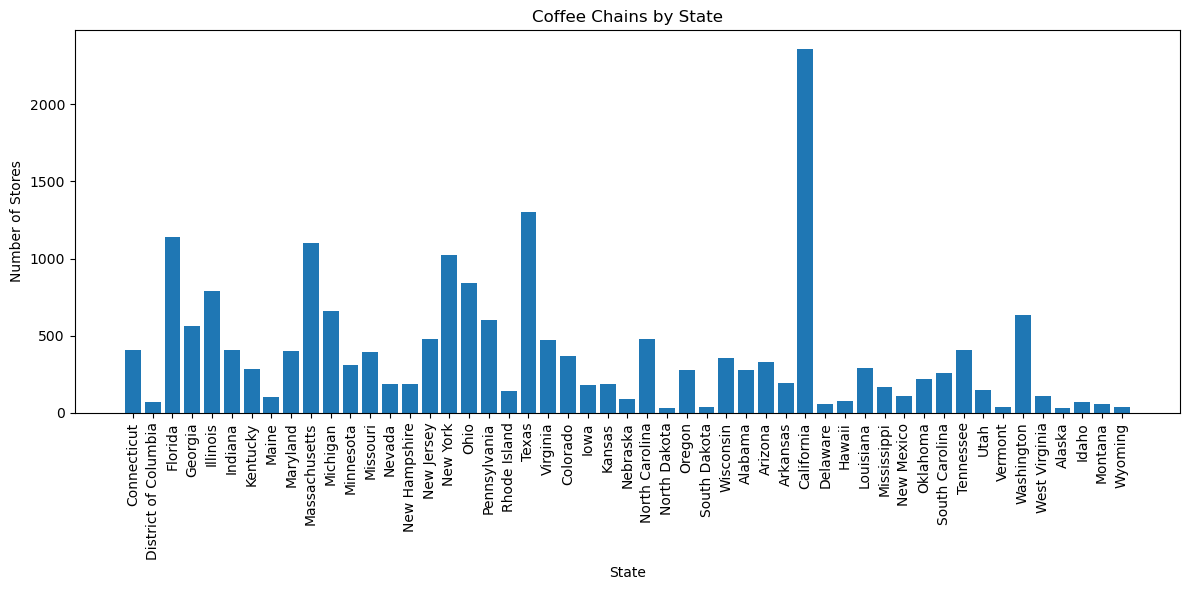

In [205]:
import matplotlib.pyplot as plt

# Example: Create a bar plot of coffee chains by state
plt.figure(figsize=(12, 6))
plt.bar(chain_state_counts['State'], chain_state_counts['Location Count'])
plt.xlabel('State')
plt.ylabel('Number of Stores')
plt.title('Coffee Chains by State')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

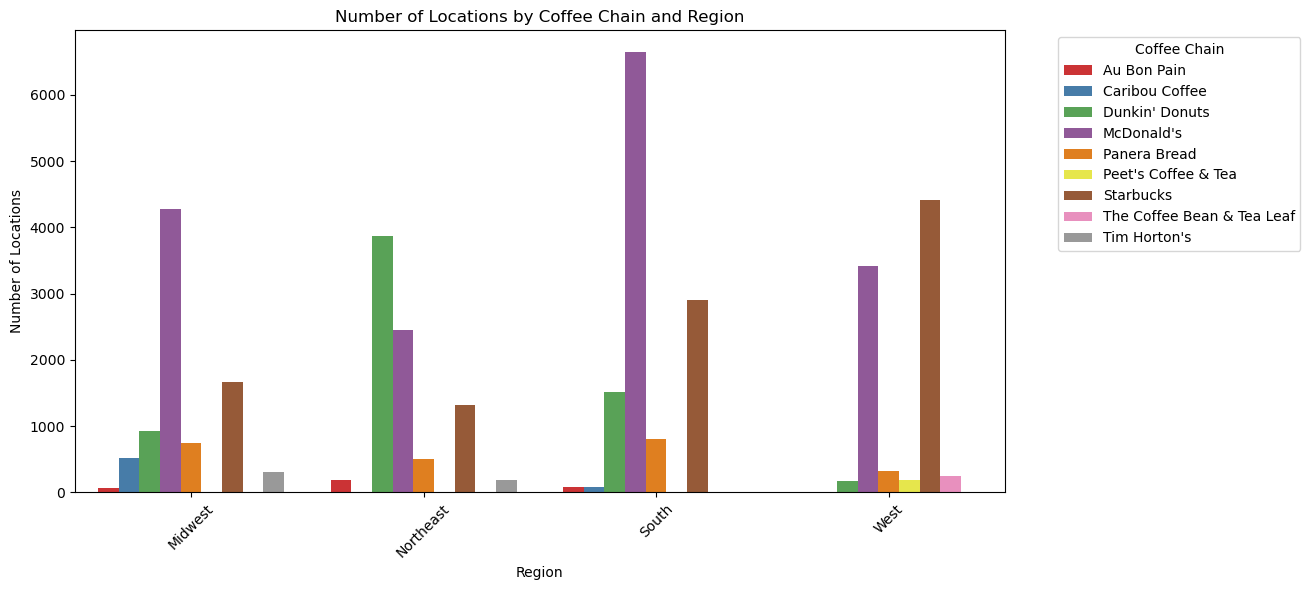

In [206]:
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.barplot(x='Region', y='Location Count', hue='Coffee Chain', data=chain_region_counts, palette='Set1')
plt.xlabel('Region')
plt.ylabel('Number of Locations')
plt.title('Number of Locations by Coffee Chain and Region')
plt.xticks(rotation=45)
plt.legend(title='Coffee Chain', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

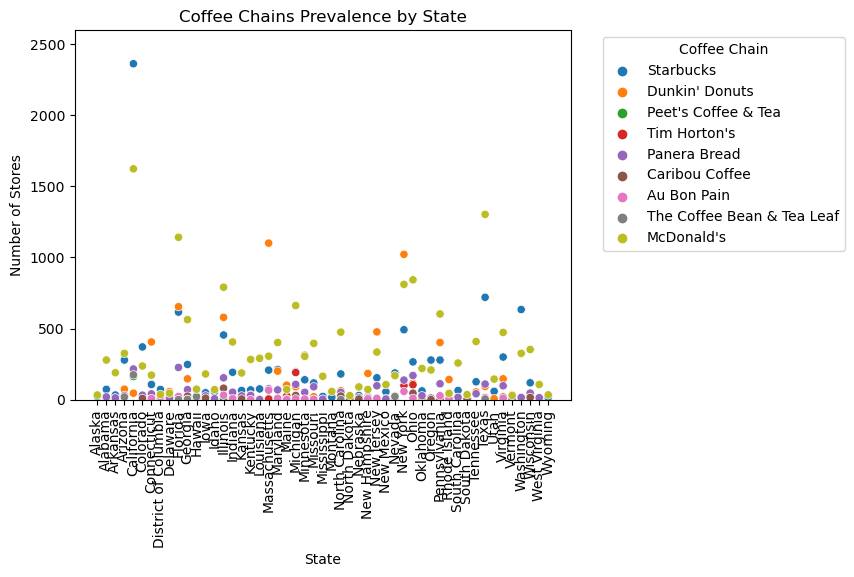

In [207]:
# Scatter plot of the number of stores for all coffee chains by state
sns.scatterplot(x='State', y='Location Count', hue='Coffee Chain', data=merged_data)
plt.xlabel('State')
plt.ylabel('Number of Stores')
plt.title('Coffee Chains Prevalence by State')
plt.xticks(rotation=90)
plt.legend(title='Coffee Chain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, max(merged_data['Location Count']) * 1.1)

plt.show()

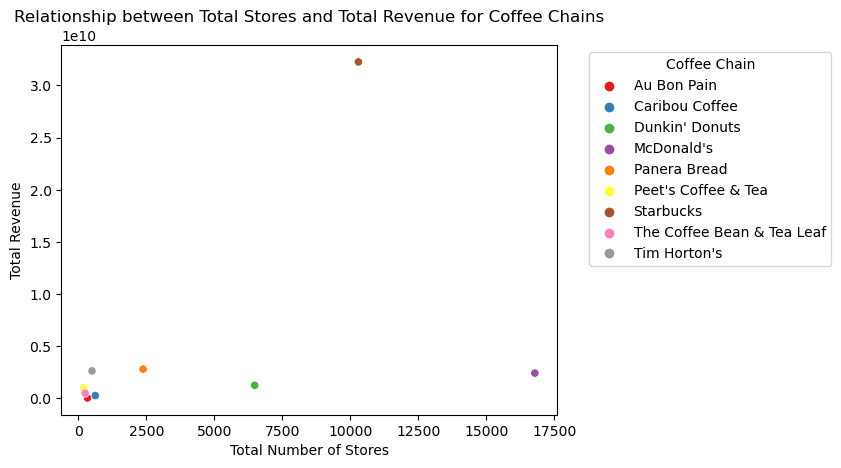

Correlation between Total Stores and Total Revenue: 0.42657135520620265


In [208]:
chain_totals = merged_data.groupby('Coffee Chain').agg({'Location Count': 'sum', 'Revenue': 'first'}).reset_index()

sns.scatterplot(x='Location Count', y='Revenue', hue='Coffee Chain', data=chain_totals, palette='Set1')
plt.xlabel('Total Number of Stores')
plt.ylabel('Total Revenue')
plt.title('Relationship between Total Stores and Total Revenue for Coffee Chains')
plt.legend(title='Coffee Chain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

correlation = chain_totals['Location Count'].corr(chain_totals['Revenue'])
print(f'Correlation between Total Stores and Total Revenue: {correlation}')

In [209]:
import plotly.express as px

fig = px.scatter(merged_data[merged_data['Coffee Chain'] == 'Starbucks'], x='Location Count', y='Population', text='State Abbreviation')

fig.update_xaxes(type="log")
fig.update_yaxes(range=[0, 40000000])
fig.update_traces(textposition='top center')
fig.update_layout(xaxis_title='Number of Starbucks Stores', yaxis_title='Population', title='Starbucks Stores vs. Population by State')

fig.show()

In [210]:
fig = px.scatter(merged_data[merged_data['Coffee Chain'] == 'Caribou Coffee'], x='Location Count', y='Population', text='State Abbreviation')

fig.update_xaxes(type="log")
fig.update_yaxes(range=[0, 15000000])
fig.update_traces(textposition='top center')
fig.update_layout(xaxis_title='Number of Caribou Coffee Stores', yaxis_title='Population', title='Caribou Coffee Stores vs. Population by State')

fig.show()

In [194]:
fig = px.scatter(merged_data[merged_data['Coffee Chain'] == "Tim Horton's"], x='Location Count', y='Population', text='State Abbreviation')

fig.update_xaxes(type="log")
fig.update_yaxes(range=[0, 15000000])
fig.update_traces(textposition='top center')
fig.update_layout(xaxis_title="Number of Tim Horton's Stores", yaxis_title='Population', title="Tim Horton's Stores vs. Population by State")

fig.show()